## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5]
redice_lr_patient = [5, 10]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0901 16:47:38.693055 16196 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5


W0901 16:47:38.875607 16196 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0901 16:47:38.883582 16196 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0901 16:47:38.948414 16196 deprecation.py:323] From C:\Users\an_fl\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

Epoch 14/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.2460 - acc: 0.5662 - val_loss: 1.4771 - val_acc: 0.4803
Epoch 15/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.2272 - acc: 0.5724 - val_loss: 1.4699 - val_acc: 0.4859
Epoch 16/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2058 - acc: 0.5824 - val_loss: 1.4742 - val_acc: 0.4845
Epoch 17/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1867 - acc: 0.5892 - val_loss: 1.4663 - val_acc: 0.4900
Epoch 18/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.1715 - acc: 0.5956 - val_loss: 1.4645 - val_acc: 0.4861
Epoch 19/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.1508 - acc: 0.6034 - val_loss: 1.4801 - val_acc: 0.4888
Epoch 20/25
50000/50000 [==============================] - 9s 190us/step - loss: 1.1335 - acc: 0.6096 - val_loss: 1.4647 - val_acc: 0.4939
Epoch 21/25
50000/50000 [==

50000/50000 [==============================] - 8s 154us/step - loss: 2.2181 - acc: 0.2695 - val_loss: 2.1030 - val_acc: 0.3134
Epoch 2/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.7555 - acc: 0.3882 - val_loss: 1.8415 - val_acc: 0.3699
Epoch 3/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6319 - acc: 0.4297 - val_loss: 1.6924 - val_acc: 0.4088
Epoch 4/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5558 - acc: 0.4560 - val_loss: 1.6371 - val_acc: 0.4233
Epoch 5/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.5030 - acc: 0.4723 - val_loss: 1.6034 - val_acc: 0.4380
Epoch 6/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.4587 - acc: 0.4886 - val_loss: 1.5675 - val_acc: 0.4518
Epoch 7/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.4218 - acc: 0.5010 - val_loss: 1.5497 - val_acc: 0.4570
Epoch 8/25
50000/50000 [=====================


Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 24/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.3784 - acc: 0.8971 - val_loss: 1.5521 - val_acc: 0.5367
Epoch 25/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.3622 - acc: 0.9063 - val_loss: 1.5715 - val_acc: 0.5306
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)             

50000/50000 [==============================] - 10s 197us/step - loss: 1.1195 - acc: 0.6132 - val_loss: 1.4630 - val_acc: 0.4864
Epoch 11/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.0923 - acc: 0.6239 - val_loss: 1.4565 - val_acc: 0.4856
Epoch 12/25
50000/50000 [==============================] - 12s 245us/step - loss: 1.0640 - acc: 0.6370 - val_loss: 1.4370 - val_acc: 0.4934
Epoch 13/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.0371 - acc: 0.6441 - val_loss: 1.4192 - val_acc: 0.5004
Epoch 14/25
50000/50000 [==============================] - 9s 190us/step - loss: 1.0116 - acc: 0.6543 - val_loss: 1.4495 - val_acc: 0.4949
Epoch 15/25
50000/50000 [==============================] - 9s 177us/step - loss: 0.9881 - acc: 0.6639 - val_loss: 1.4288 - val_acc: 0.4984
Epoch 16/25
50000/50000 [==============================] - 10s 190us/step - loss: 0.9640 - acc: 0.6752 - val_loss: 1.4495 - val_acc: 0.4927
Epoch 17/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.8451 - acc: 0.3644 - val_loss: 2.1614 - val_acc: 0.3325
Epoch 2/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.5393 - acc: 0.4526 - val_loss: 5.7014 - val_acc: 0.1883
Epoch 3/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.4305 - acc: 0.4927 - val_loss: 2.1111 - val_acc: 0.3207
Epoch 4/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.3470 - acc: 0.5224 - val_loss: 2.2746 - val_acc: 0.3286
Epoch 5/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.2885 - acc: 0.5428 - val_loss: 2.0806 - val_acc: 0.3442
Epoch 6/25
50000/50000 [==============================] - 10s 192us/step - loss: 1.2325 - acc: 0.5624 - val_loss: 1.8546 - val_acc: 0.3534
Epoch 7/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.1853 - acc: 0.5805 - val_loss: 1.6558 

50000/50000 [==============================] - 9s 175us/step - loss: 0.9584 - acc: 0.6776 - val_loss: 1.4753 - val_acc: 0.4876
Epoch 23/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.9395 - acc: 0.6830 - val_loss: 1.4995 - val_acc: 0.4872

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 24/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.8833 - acc: 0.7096 - val_loss: 1.4332 - val_acc: 0.5063
Epoch 25/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.8735 - acc: 0.7129 - val_loss: 1.4343 - val_acc: 0.5072
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)            

Epoch 9/25
50000/50000 [==============================] - 10s 192us/step - loss: 1.5361 - acc: 0.4646 - val_loss: 1.6643 - val_acc: 0.4196
Epoch 10/25
50000/50000 [==============================] - 11s 226us/step - loss: 1.5085 - acc: 0.4753 - val_loss: 1.6427 - val_acc: 0.4282
Epoch 11/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.4830 - acc: 0.4834 - val_loss: 1.6285 - val_acc: 0.4336
Epoch 12/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.4605 - acc: 0.4921 - val_loss: 1.6083 - val_acc: 0.4430
Epoch 13/25
50000/50000 [==============================] - 12s 242us/step - loss: 1.4379 - acc: 0.4992 - val_loss: 1.5971 - val_acc: 0.4434
Epoch 14/25
50000/50000 [==============================] - 12s 245us/step - loss: 1.4171 - acc: 0.5072 - val_loss: 1.5969 - val_acc: 0.4439
Epoch 15/25
50000/50000 [==============================] - 12s 238us/step - loss: 1.3978 - acc: 0.5134 - val_loss: 1.5787 - val_acc: 0.4501
Epoch 16/25
50000/5000

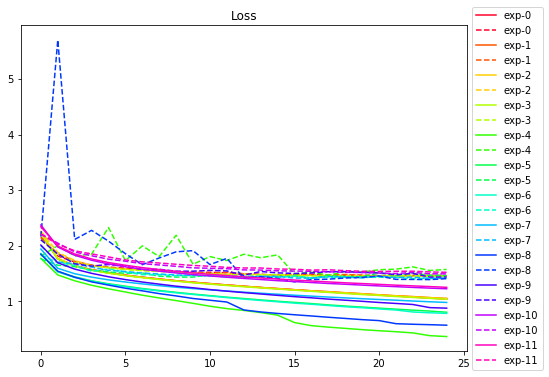

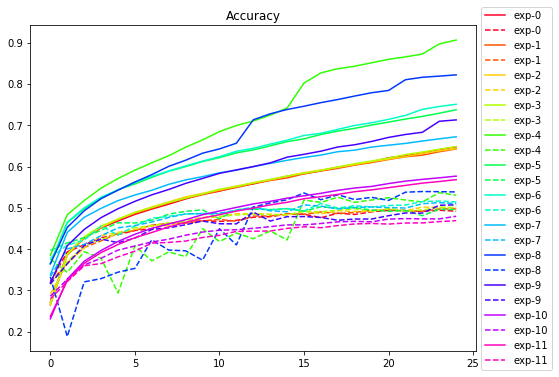

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()